<a href="https://colab.research.google.com/github/Farii01/Internship_PINN_work/blob/main/optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install git+https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git

  Cloning https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git to /tmp/pip-req-build-hqxquw7f
  Running command git clone --filter=blob:none --quiet https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git /tmp/pip-req-build-hqxquw7f
  Resolved https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git to commit 87d5eab82dbae0c55a8d93113cd4ac6db38a0bf0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pygeotools
import torch
import torch.nn as nn
import numpy

### Retrieving the data

In [3]:
model_path = "/content/COVOBS-x2_400reals.hdf5"

pygeo = pygeotools.pygeotools()
model_name=  "COVOBS-x2_400reals.hdf5"
pygeo.loadModel(
    modelName="COVOBS-x2_400reals.hdf5",
    modelType="covobs_hdf5",
    modelPath=model_path
)

pygeo.isLoaded("COVOBS-x2_400reals.hdf5")  # Should return True

pygeotools was initialized with `verbose=True`.


True

In [4]:
# Setting the grid
pygeo.setGrid("1deg")

# Creating the context
context = {
    "lmax": 13,
    "r": pygeo.constants["rCore"]
}

In [5]:
# Computing the MF and SV
MF = pygeo.addMeasure("COVOBS-x2_400reals.hdf5", "MF", context)
SV = pygeo.addMeasure("COVOBS-x2_400reals.hdf5", "SV", context)

13


In [6]:
# Retrieving the grid
_, (thetas, phis) = pygeo.getCurrentGrid()

In [7]:
# Selecting the data
Br = pygeo.selectFromMeasure("COVOBS-x2_400reals.hdf5", MF, options={"component": "r", "time": 2020})
dBrdt = pygeo.selectFromMeasure("COVOBS-x2_400reals.hdf5", SV, options={"component": "r", "time": 2020})

i1, i2 = 20, 40
j1, j2 = 20, 60

# Computing the derivative wrt theta and phi of the MF
dBrdth = numpy.gradient(Br, thetas, axis=0)[i1:i2,j1:j2,...]
dBrdph = numpy.gradient(Br, phis, axis=1)[i1:i2,j1:j2,...]

Br = Br[i1:i2,j1:j2,...]
dBrdt = dBrdt[i1:i2,j1:j2,...]

# Slicing the grid
thetas_bis = thetas[i1:i2]
phis_bis = phis[j1:j2]

### Defining the NN model

In [8]:
node_inputs = 2
node_outputs = 2
node_layer = 64
hidden_layers = 3

In [9]:
#  Defining the NN
# For now, it has one hidden layer with 32 nodes
# The activation functions are TANH
class CoreFlowPINN(nn.Module):
    def __init__(self):
        super(CoreFlowPINN, self).__init__()

        layers = []

        layers.append(nn.Linear(node_inputs, node_layer))
        layers.append(nn.Tanh())

        for _ in range(hidden_layers):
            layers.append(nn.Linear(node_layer, node_layer))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(node_layer, node_outputs))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [10]:
# Shaping everything for the NN

# Creating the grid
thetas_grid, phis_grid = numpy.meshgrid(thetas_bis, phis_bis, indexing="ij")

# Creating the (flatten) grid points
thetas_flatten = thetas_grid.flatten()
phis_flatten = phis_grid.flatten()

# Creating grid tensors to feed the NN
thetas_nn = torch.tensor(thetas_flatten[:, None], dtype=torch.float32, requires_grad=True)
phis_nn = torch.tensor(phis_flatten[:, None], dtype=torch.float32, requires_grad=True)

# Creating tensors for the MF and SV
Br_nn = torch.tensor(Br.flatten()[:, None], dtype=torch.float32)
dBrdt_nn = torch.tensor(dBrdt.flatten()[:, None], dtype=torch.float32)
dBrdth_nn = torch.tensor(dBrdth.flatten()[:, None], dtype=torch.float32)
dBrdph_nn = torch.tensor(dBrdph.flatten()[:, None], dtype=torch.float32)

# Ravel the angles
inputs = torch.cat([thetas_nn, phis_nn], dim=1)

In [16]:
# Creating the model
model = CoreFlowPINN()

# Using ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), 0.001)

# For the loss history
loss_history = []

In [18]:
λ

10

In [17]:
"""
We want to solve the radial induction equation at the CMB
    dBr / dt + ∇h • (Uh Br) = 0

with some quasi-geostrophic condition (meaning the flow will partly align along the axis of rotation, making columns-like flow)
    ∇h • (Uh cos(θ)) = 0

As the flow is incompressible, it is subject to ∇ • U = 0. As a result, it admits a unique toroidal-poloidal decomposition:
    Uh = ∇ x (r T) + ∇ (r S)

Thus, instead of directly predicting uθ and uφ, it appears clever to predict T and S as it already enforces the incompressibility condition.

In spherical coordinates, one has
    uθ = -(dT/dφ) / sin(θ) + dS/dθ
    uφ = dT/dθ + (dS/dφ) / sin(θ)
"""

r = torch.tensor(pygeo.constants["rCore"]) # placing ourselves at the CMB

def compute_loss(model, inputs, thetas_nn, phis_nn, Br_nn, dBrdt_nn, dBrdth_nn, dBrdph_nn, r, λ=10):
    # Retrieving the predicted flow
    u_pred = model(inputs)

    # Retrieving the toroidal and poloidal components
    T = u_pred[:, 0:1]
    S = u_pred[:, 1:2]

    # First derivatives of T and S
    dT_dth = torch.autograd.grad(T, thetas_nn, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True)[0]
    dT_dph = torch.autograd.grad(T, phis_nn, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True)[0]
    dS_dth = torch.autograd.grad(S, thetas_nn, grad_outputs=torch.ones_like(S), create_graph=True, retain_graph=True)[0]
    dS_dph = torch.autograd.grad(S, phis_nn, grad_outputs=torch.ones_like(S), create_graph=True, retain_graph=True)[0]

    sin_th = torch.sin(thetas_nn)
    cos_th = torch.cos(thetas_nn)

    # Defining u_th and u_ph with T and S
    u_th = -dT_dph / sin_th + dS_dth
    u_ph = dT_dth + dS_dph / sin_th

    # Computing ∇h • Uh
    u_th_sin_th = u_th * sin_th
    d_u_th_sin_th_dth = torch.autograd.grad(u_th_sin_th, thetas_nn, grad_outputs=torch.ones_like(u_th_sin_th), create_graph=True, retain_graph=True)[0]
    d_u_ph_dph = torch.autograd.grad(u_ph, phis_nn, grad_outputs=torch.ones_like(u_ph), create_graph=True, retain_graph=True)[0]
    divH_uH = (1 / (r * sin_th)) * (d_u_th_sin_th_dth + d_u_ph_dph)

    # Computing ∇h Br
    gradH_Br_th = (1 / r) * dBrdth_nn
    gradH_Br_ph = (1 / (r * sin_th)) * dBrdph_nn

    # Wrapping the induction equation
    L1 = dBrdt_nn + Br_nn * divH_uH + u_th * gradH_Br_th + u_ph * gradH_Br_ph
    L1_loss = (L1**2).mean()

    # Computing L2
    L2 = divH_uH * cos_th - u_th * sin_th / r
    L2_loss = (L2**2).mean()

    # Final loss
    Loss = L1_loss + λ * L2_loss

    return Loss, L1_loss, L2_loss



for epoch in range(1000):
    optimizer.zero_grad()

    Loss, L1_loss, L2_loss = compute_loss(
        model, inputs, thetas_nn, phis_nn,
        Br_nn, dBrdt_nn, dBrdth_nn, dBrdph_nn,
        r, λ=10
    )

    Loss.backward()
    optimizer.step()

    loss_history.append(Loss.item())

    print(f" Epoch {epoch} --- Loss {Loss.item():.6f}--- Loss_L1 {L1_loss.item():.6f}--- Loss_L2 {L2_loss.item():.6f}")



 Epoch 0 --- Loss 20426488.000000--- Loss_L1 20426488.000000--- Loss_L2 0.000000
 Epoch 1 --- Loss 19916288.000000--- Loss_L1 19916288.000000--- Loss_L2 0.000000
 Epoch 2 --- Loss 19420332.000000--- Loss_L1 19420332.000000--- Loss_L2 0.000000
 Epoch 3 --- Loss 18924666.000000--- Loss_L1 18924666.000000--- Loss_L2 0.000000
 Epoch 4 --- Loss 18416418.000000--- Loss_L1 18416418.000000--- Loss_L2 0.000000
 Epoch 5 --- Loss 17884080.000000--- Loss_L1 17884080.000000--- Loss_L2 0.000000
 Epoch 6 --- Loss 17317744.000000--- Loss_L1 17317744.000000--- Loss_L2 0.000000
 Epoch 7 --- Loss 16709094.000000--- Loss_L1 16709094.000000--- Loss_L2 0.000000
 Epoch 8 --- Loss 16051598.000000--- Loss_L1 16051598.000000--- Loss_L2 0.000000
 Epoch 9 --- Loss 15340884.000000--- Loss_L1 15340884.000000--- Loss_L2 0.000000
 Epoch 10 --- Loss 14575176.000000--- Loss_L1 14575176.000000--- Loss_L2 0.000000
 Epoch 11 --- Loss 13755761.000000--- Loss_L1 13755761.000000--- Loss_L2 0.000000
 Epoch 12 --- Loss 1288750

### Learning

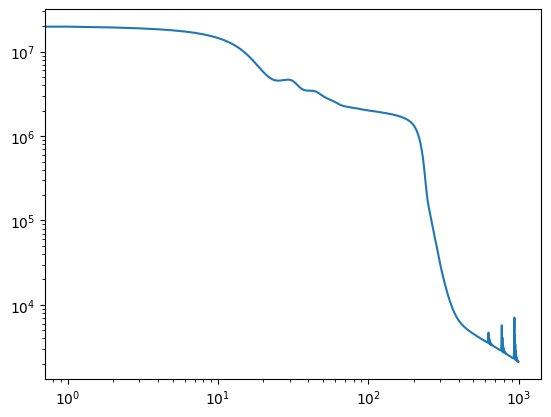

In [13]:
import matplotlib.pyplot as plt
plt.loglog(loss_history)

### Predictions

In [14]:
u_th_map = u_th.reshape(Br.shape).detach().numpy()
u_ph_map = u_ph.reshape(Br.shape).detach().numpy()

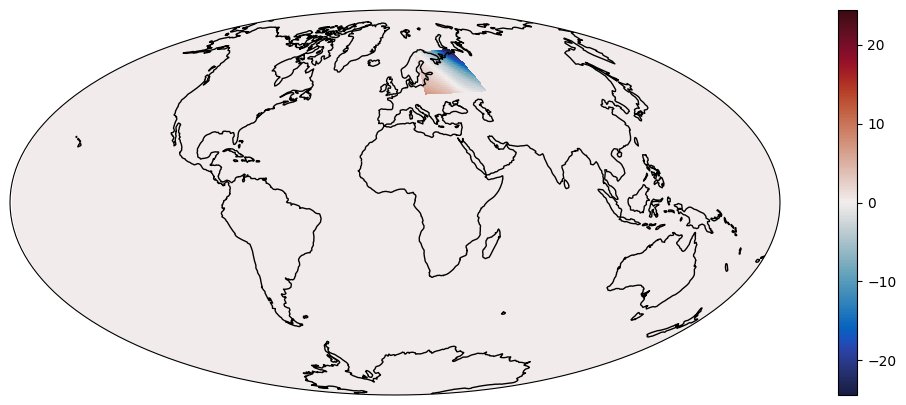

In [15]:
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

u_th_full = numpy.zeros((thetas.size, phis.size))
u_th_full[i1:i2,j1:j2] = u_th_map

thetas_bis_deg = numpy.rad2deg(thetas)
phis_bis_deg = numpy.rad2deg(phis)

latitudes = pygeo.convertThetasToLatitudes(thetas)
longitudes = pygeo.convertPhisToLongitudes(phis)

lat_grid, lon_grid = numpy.meshgrid(latitudes, longitudes, indexing="ij")

fig = plt.figure(figsize=(15,5))

# Set the projection to Hammer and add the axes
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Aitoff())

u_max = numpy.max(numpy.abs(u_th_full))

# Use `pcolormesh` to project the data onto the map
pcol = ax.pcolormesh(lon_grid, lat_grid, u_th_full, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=-u_max, vmax=u_max)

# Add coastlines for context
ax.coastlines()

plt.colorbar(pcol)